# Contaminant Clustering

## Simple Clustering

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# for inline plots in jupyter
%matplotlib inline

import numpy as np
import math

In [2]:
import datetime

import numpy as np

%load_ext autoreload
%autoreload 2

In [3]:
from popsborder.consignments import Box, Consignment
from popsborder.inputs import load_configuration_yaml_from_text
from popsborder.contamination import add_contaminant_clusters
from popsborder.outputs import pretty_consignment

In [4]:
def get_consignment(num_items):
    """Get basic consignment with given number of items all in one box"""
    items = np.zeros(num_items, dtype=int)
    return Consignment(
        flower="Rosa",
        date=datetime.date(2018, 2, 15),
        origin="Mexico",
        port="FL Miami Air CBP",
        num_items=num_items,
        items=items,
        num_boxes=1,
        boxes=[Box(items)],
        items_per_box=num_items,
        pathway="air",
    )

In [5]:
config_yaml = f"""
contamination:
    contamination_rate:
        distribution: fixed_value
        value: 0.1
    contamination_unit: item
    arrangement: clustered
    clustered:
        distribution: subset
        placement_adjustment: split
        clustering: 0.5
"""

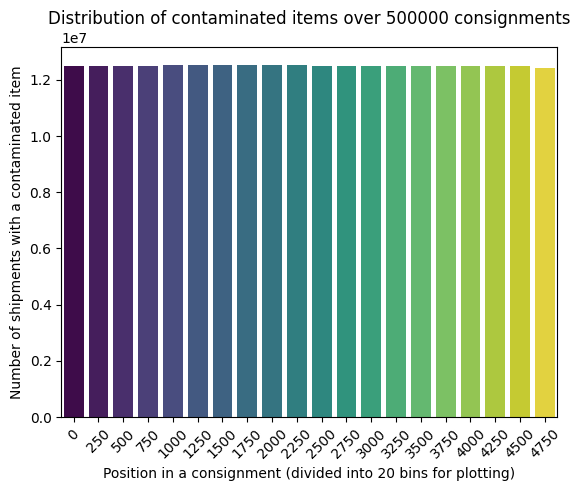

In [6]:
config = load_configuration_yaml_from_text(config_yaml)["contamination"]
contamination_rate = config["contamination_rate"]["value"]
num_items = 5000
num_consignments = 500000
all_values = np.zeros(num_items)
for i in range(num_consignments):
    consignment = get_consignment(num_items)
    add_contaminant_clusters(config, consignment)
    contaminated_items = int(num_items * contamination_rate)
    assert np.count_nonzero(consignment.items) == contaminated_items
    all_values += consignment.items

# Index
x = np.arange(len(all_values))
# Bins
num_bins = min(20, len(x))
# Bin edges
bins = np.linspace(x.min(), x.max(), num_bins + 1)
# Assign each x to a bin.
bin_indices = np.digitize(x, bins)

# Accumulate the y-values for each bin.
binned_values = np.zeros(num_bins)
x_labels = []
for i in range(1, num_bins + 1):
    # Find the original x values in this bin.
    x_in_bin = x[bin_indices == i]
    # Sum y-values in each bin.
    binned_values[i - 1] = all_values[bin_indices == i].sum()
    # Use the first x value for labeling.
    x_labels.append(x_in_bin[0] if len(x_in_bin) > 0 else None)

# Filter out empty bins if necessary.
valid_indices = [i for i, label in enumerate(x_labels) if label is not None]
x_labels = [x_labels[i] for i in valid_indices]
binned_values = np.array([binned_values[i] for i in valid_indices])

sns.barplot(x=x_labels, y=binned_values, hue=x_labels, legend=False, palette="viridis")
plt.title(f"Distribution of contaminated items over {num_consignments} consignments")
plt.xlabel(f"Position in a consignment (divided into {num_bins} bins for plotting)")
plt.ylabel("Number of shipments with a contaminated item")
plt.xticks(rotation=45)
plt.show()

In [7]:
print(bins)

[   0.    249.95  499.9   749.85  999.8  1249.75 1499.7  1749.65 1999.6
 2249.55 2499.5  2749.45 2999.4  3249.35 3499.3  3749.25 3999.2  4249.15
 4499.1  4749.05 4999.  ]


## Exploring Distributions

In [8]:
# import seaborn
import seaborn as sns

# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={"figure.figsize": (5, 5)})

In [9]:
from scipy.stats import beta

infest_beta = beta.rvs(4, 60, size=10000)

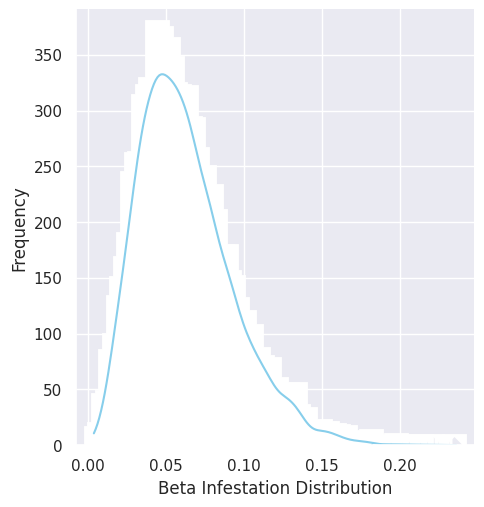

In [10]:
ax = sns.displot(
    infest_beta, kde=True, bins=100, color="skyblue", linewidth=15, alpha=1
)
ax.set(xlabel="Beta Infestation Distribution", ylabel="Frequency")

In [11]:
# Choose infestation rate for shipment from beta distribution
infest_rate = beta.rvs(4, 60, size=1)[0]
print("Infestation rate:", round(infest_rate, 4))

Infestation rate: 0.0087


In [12]:
num_stem = np.random.randint(1, high=1000000, size=1)[0]  # QUANTITY

# Calculate number of pests in shipment based on infestation rate.
num_pest = int(num_stem * infest_rate)
print("Num stems: ", int(num_stem))
print("Num pests:", num_pest)
np.arange(num_stem)

Num stems:  420997
Num pests: 3654


array([     0,      1,      2, ..., 420994, 420995, 420996],
      shape=(420997,))

In [13]:
# Infest stems using uniform distribution
infest_stem_unif = np.random.choice(int(num_stem), num_pest, replace=False)

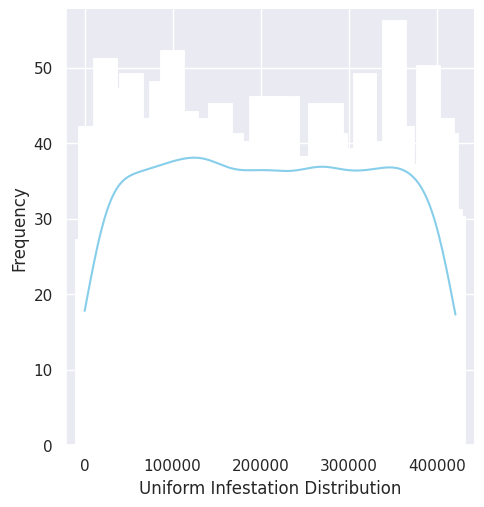

In [14]:
ax = sns.displot(
    infest_stem_unif, kde=True, bins=100, color="skyblue", linewidth=15, alpha=1
)
ax.set(xlabel="Uniform Infestation Distribution", ylabel="Frequency")

In [15]:
from scipy.stats import gamma

# Infest stems using gamma distribution to create cluster of pests.
infest_clust = gamma.rvs(
    3, scale=500, size=40000
)  # rvs(a, loc=0, scale=1, size=1, random_state=None)
infest_clust = [round(x) for x in infest_clust]

# Insert infested cluster of stems into shipment at random position
start_clust = np.random.randint(1, high=num_stem - max(infest_clust), size=1)
infest_stem_clust = infest_clust + start_clust

print("Size of cluster:", int(max(infest_stem_clust) - min(infest_stem_clust)), "stems")

Size of cluster: 9072 stems


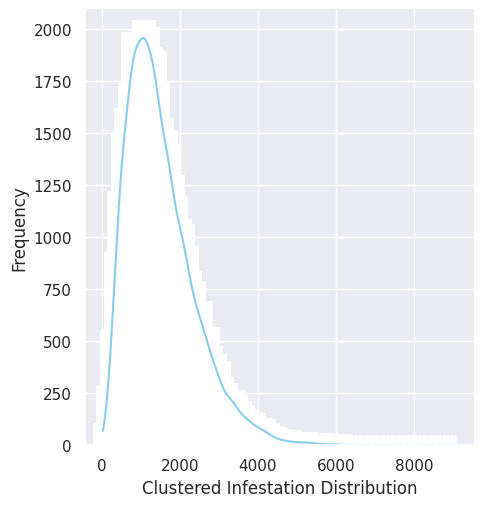

In [16]:
ax = sns.displot(
    infest_clust, kde=True, bins=100, color="skyblue", linewidth=15, alpha=1
)
ax.set(xlabel="Clustered Infestation Distribution", ylabel="Frequency")

In [17]:
num_boxes = math.ceil(num_stem / 200)
print(num_boxes)

2105
